Idea: préciser pourquoi prendre une certaine partie des données => dans la data exploration analysis mettre en avant les inégalités et cooks distance, beaucpup dépasse le rule of thumb 
Solution: prendre un nombre maximal de lancé par combinaison de participants/coin

ON essaye de prendre le meme nombre de lancés par coin/person

heatmap ? 



In [1]:
library(dplyr)
library(ggplot2)
library(cat)
library(pROC)

set.seed(123)


Attachement du package : 'dplyr'


Les objets suivants sont masqu'es depuis 'package:stats':

    filter, lag


Les objets suivants sont masqu'es depuis 'package:base':

    intersect, setdiff, setequal, union


Type 'citation("pROC")' for a citation.


Attachement du package : 'pROC'


Les objets suivants sont masqu'es depuis 'package:stats':

    cov, smooth, var




In [2]:
df <- read.csv("coin data/analyses/data-agg.csv",header=T)
n <- nrow(df)
dfHeads <- df[,-c(2,4)] # heads to heads
dfTails <- df[,-c(1,3)] # tails to heads
dfTails[,1] <- dfTails[,2]-dfTails[,1] # tails to tails
names(dfHeads) <- names(dfTails) <- c("y", "m", "person", "coin")
start <- rep(c("heads","tails"),c(n,n))
df <- rbind(dfHeads,dfTails)
df$person <- factor(df$person); df$coin <- factor(df$coin); df$start <- factor(start) # nolint

In [3]:
df_long <- read.csv("coin data/analyses/data-long.csv",header=T)
df_time_agg <- read.csv("coin data/analyses/df-time-agg.csv",header=T)
df_time <- read.csv("coin data/analyses/df-time.csv",header=T)

In [4]:
names(df_time_agg)

[1] "heads_heads"      "tails_heads"      "N_start_heads_up" "N_start_tails_up"
 [5] "same_side"        "N"                "person"           "coin"            
 [9] "agg"              "from"             "to"               "mean_toss"

In [5]:
# POur prendre les X premieres lignes dans le data set 
# # Sélection des 3 premières lignes pour chaque combinaison Fruit-Couleur
# selected_data <- data %>%
#   group_by(Fruit, Couleur) %>%
#   slice_head(n = 3) %>%
#   ungroup()

# # Résultat
# print(selected_data)

# Data Analysis

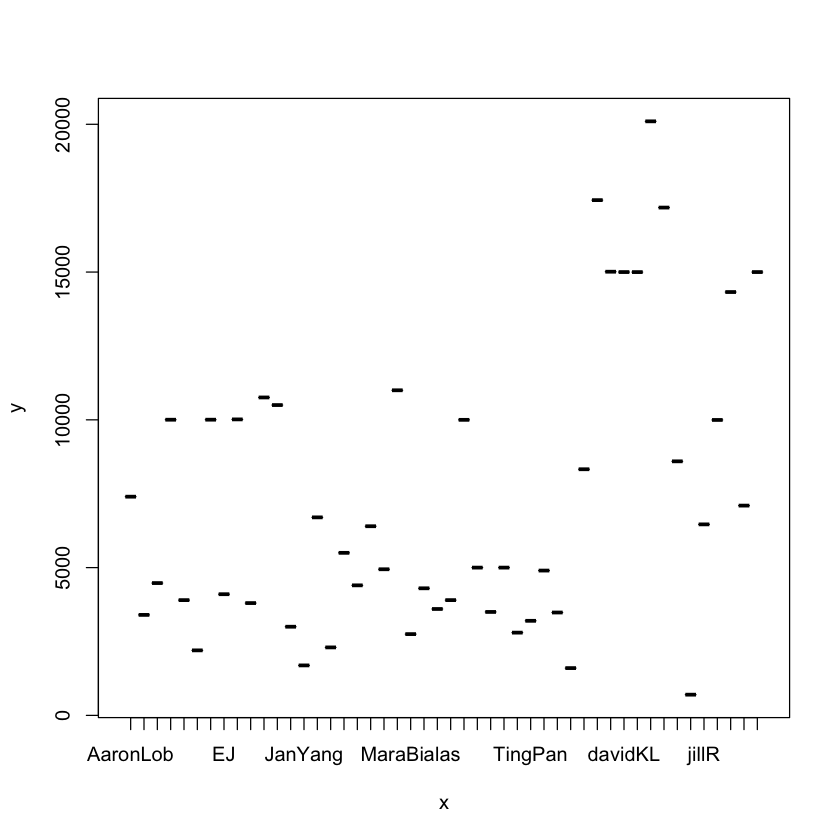

In [6]:
nb_toss_per_person <- df %>%
    select(m, person) %>%
    group_by(person) %>%
    summarise(m = sum(m))

plot(nb_toss_per_person$person, nb_toss_per_person$m)

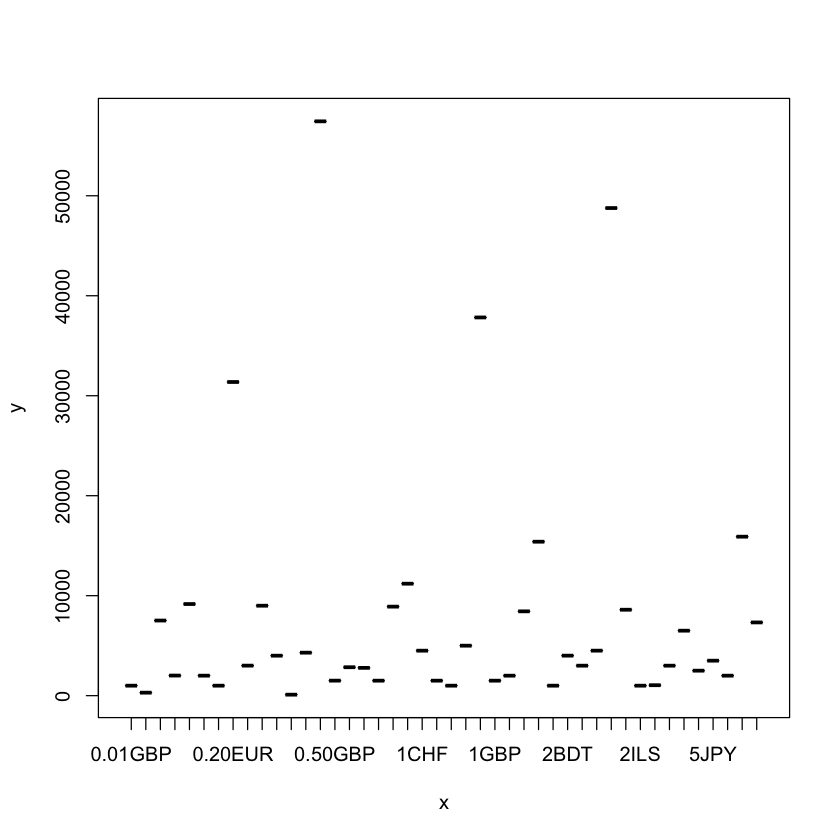

In [7]:
nb_toss_per_coin <- df %>%
    select(m, coin) %>%
    group_by(coin) %>%
    summarise(m = sum(m))

plot(nb_toss_per_coin$coin, nb_toss_per_coin$m)

In [8]:
df$personNumber <- as.numeric(factor(df$person))
df$coinNumber <- as.numeric(factor(df$coin))

table(df$personNumber)
table(df$coinNumber)


 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 
10  6  8  4  8  6 10 10  6  8  6 10  8  4 14  6 10 10 14 12 14  6 10  8  8  6 
27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 
10  8 10  6  8 10  8  4  4 16 12  2 10 22 16  2  2  4 10 16  2 18 


 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 
 2  2 12  2 12  2  2 40  4 10  4  2  8 64  2  6  6  2 14 22  8  2  2 10 50  4 
27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 
 2  2  4  2  4  6  4 56  2  2  2  2 14  4  4  2 14  2 

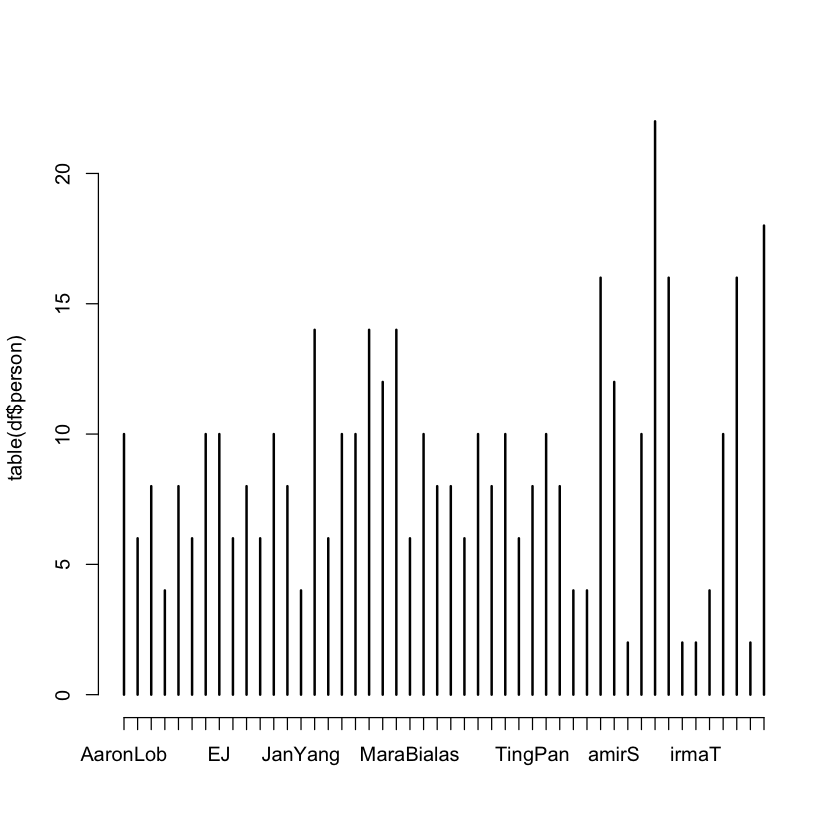

In [9]:
plot(table(df$person))

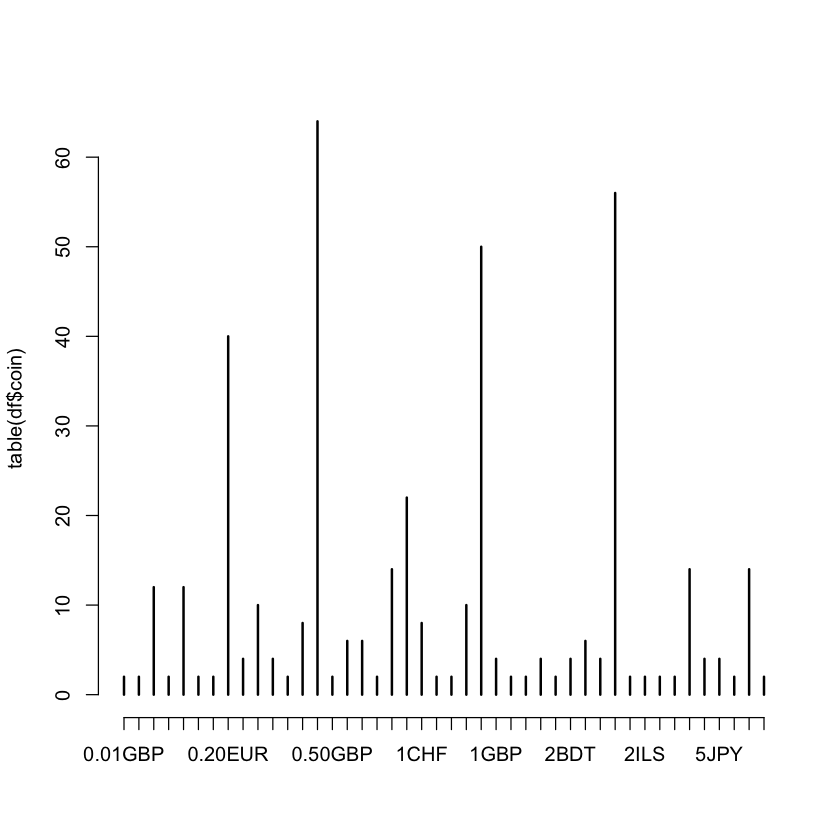

In [10]:
plot(table(df$coin))

As we can see, participants do not toss the same number of coins, so those who toss a lot will strongly influence the model’s results.

Similarly for the coins, those that appear less frequently have little influence on the model.

# Data selection


As some participant ou some coin were tossed a larger number of time than other, they will have more impact on regression we want to do. So, to limit that regression, we want to take a maximum number of tosses per combination person/coin. The goal is that all data are under 4/(number of data) -> Cook's distance

For the logistic regression and WLS, we take a random number of line in the table 'df_time_agg' et we choose to not take into account the learning process (if there is one)

In [43]:
sampled_data <- df_time_agg %>%
  group_by(person, coin) %>%
  sample_n(size = min(3, n()), replace = FALSE) %>%
  ungroup() %>%
  mutate(tails_tails = N_start_tails_up - tails_heads) %>%
  select(heads_heads, tails_tails, N, person, coin)

print(sampled_data)


# A tibble: 628 x 5
   heads_heads tails_tails     N person   coin   
         <int>       <int> <int> <chr>    <chr>  
 1          23          22   100 AaronLob 0.20EUR
 2          35          26   100 AaronLob 0.20EUR
 3          29          27   100 AaronLob 0.20EUR
 4          19          37   100 AaronLob 0.50EUR
 5          23          20   100 AaronLob 0.50EUR
 6          23          23   100 AaronLob 0.50EUR
 7          27          26   100 AaronLob 1DEM   
 8          28          18   100 AaronLob 1DEM   
 9          31          26   100 AaronLob 1DEM   
10          21          30   100 AaronLob 1EUR   
# i 618 more rows


In [44]:
nb_toss_per_person_1 <- sampled_data %>%
    select(N, person) %>%
    group_by(person) %>%
    summarise(N = sum(N))


nb_toss_per_person_1

person,N
<chr>,<int>
AaronLob,1500
AdrianKarami,900
AndreeaZetea,1209
AntonZoubek,600
ArneJohn,1200
BohanFu,900
ChrisGabrielIslam,1502
EJ,1400
FelipeFontanaVieira,903


Participants throw between 500 and 5500 tosses

In [45]:
nb_toss_per_coin_1 <- sampled_data %>%
    select(N, coin) %>%
    group_by(coin) %>%
    summarise(N = sum(N))


table(nb_toss_per_coin_1$N)


 100  300  301  304  305  313  600  601  602  900  916  930 1200 1500 1507 1801 
   1   13    2    1    1    1    6    1    1    1    1    1    2    1    1    1 
1813 2000 2100 2102 3100 6015 7506 8413 9659 
   1    1    1    1    1    1    1    1    1 

Coin are used between 100 and 16098 times

In [46]:
sampled_data_model <- sampled_data %>%
    mutate(y = heads_heads + tails_tails) %>%
    rename(m=N) %>%
    select(y,m,person,coin) %>%
    group_by(person, coin) %>%
    summarize(m=sum(m), y=sum(y))

print(sampled_data_model)

table(sampled_data_model$m)

`summarise()` has grouped output by 'person'. You can override using the
`.groups` argument.


# A tibble: 211 x 4
# Groups:   person [48]
   person       coin        m     y
   <chr>        <chr>   <int> <int>
 1 AaronLob     0.20EUR   300   162
 2 AaronLob     0.50EUR   300   145
 3 AaronLob     1DEM      300   156
 4 AaronLob     1EUR      300   145
 5 AaronLob     2EUR      300   164
 6 AdrianKarami 0.20EUR   300   163
 7 AdrianKarami 1GBP      300   154
 8 AdrianKarami 2EUR      300   150
 9 AndreeaZetea 0.05EUR   300   138
10 AndreeaZetea 0.25USD   300   147
# i 201 more rows



100 200 300 301 302 303 304 305 306 309 312 313 314 315 316 330 334 
  2   1 179  12   3   1   2   1   2   1   1   1   1   1   1   1   1 

# Model with new data

## Model selection with new data

In [47]:
glmIntercept1 = glm(cbind(y,m-y)~1,family=binomial,data=sampled_data_model)
#summary(glmIntercept) 

glmTotal1 = glm(cbind(y,m-y)~1+person+coin,family=binomial,data=sampled_data_model)
summary(glmTotal1)

glmPerson1 = glm(cbind(y,m-y)~1+person,family=binomial,data=sampled_data_model)
summary(glmPerson1)

glmCoin1 = glm(cbind(y,m-y)~1+coin,family=binomial,data=sampled_data_model)
#summary(glmCoin)


Call:
glm(formula = cbind(y, m - y) ~ 1 + person + coin, family = binomial, 
    data = sampled_data_model)

Coefficients: (1 not defined because of singularities)
                           Estimate Std. Error z value Pr(>|z|)    
(Intercept)                0.073945   0.134573   0.549   0.5827    
personAdrianKarami         0.013610   0.091466   0.149   0.8817    
personAndreeaZetea        -0.113325   0.084998  -1.333   0.1824    
personAntonZoubek         -0.145272   0.101801  -1.427   0.1536    
personArneJohn            -0.039789   0.079862  -0.498   0.6183    
personBohanFu             -0.063217   0.098228  -0.644   0.5199    
personChrisGabrielIslam   -0.068914   0.089506  -0.770   0.4413    
personEJ                  -0.074658   0.075530  -0.988   0.3229    
personFelipeFontanaVieira -0.078536   0.085390  -0.920   0.3577    
personFranziskaAssion      0.103785   0.077846   1.333   0.1825    
personFranziskaNippold    -0.030002   0.098006  -0.306   0.7595    
personFrederikAust 


Call:
glm(formula = cbind(y, m - y) ~ 1 + person, family = binomial, 
    data = sampled_data_model)

Coefficients:
                           Estimate Std. Error z value Pr(>|z|)    
(Intercept)                0.058684   0.051662   1.136   0.2560    
personAdrianKarami         0.016908   0.084379   0.200   0.8412    
personAndreeaZetea        -0.149731   0.077359  -1.936   0.0529 .  
personAntonZoubek         -0.118702   0.096652  -1.228   0.2194    
personArneJohn            -0.012008   0.077486  -0.155   0.8768    
personBohanFu             -0.103135   0.084354  -1.223   0.2215    
personChrisGabrielIslam   -0.090644   0.073026  -1.241   0.2145    
personEJ                  -0.058684   0.074338  -0.789   0.4299    
personFelipeFontanaVieira -0.065328   0.084254  -0.775   0.4381    
personFranziskaAssion      0.108371   0.077625   1.396   0.1627    
personFranziskaNippold    -0.052140   0.083851  -0.622   0.5341    
personFrederikAust        -0.082685   0.073048  -1.132   0.2577    

### Anova

In [48]:
anova(glmIntercept1, glmPerson1, glmCoin1, glmTotal1, test = "LRT") # person + coin 

,Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,210,252.8562,NA,NA,NA
2,163,164.7241,47,88.13213,2.618720e-04
3,167,208.4161,-4,-43.69199,7.433878e-09
4,121,124.3018,46,84.11427,5.133544e-04


### Forward/Backward selection

In [49]:
step(glmTotal1, direction = "backward", trace = 0) #person
step(glmTotal1, direction = "both", trace = 0) #person
step(glmTotal1, direction = "forward", trace = 0) # person + coin


Call:  glm(formula = cbind(y, m - y) ~ 1, family = binomial, data = sampled_data_model)

Coefficients:
(Intercept)  
    0.02531  

Degrees of Freedom: 210 Total (i.e. Null);  210 Residual
Null Deviance:	    252.9 
Residual Deviance: 252.9 	AIC: 1551


Call:  glm(formula = cbind(y, m - y) ~ 1, family = binomial, data = sampled_data_model)

Coefficients:
(Intercept)  
    0.02531  

Degrees of Freedom: 210 Total (i.e. Null);  210 Residual
Null Deviance:	    252.9 
Residual Deviance: 252.9 	AIC: 1551


Call:  glm(formula = cbind(y, m - y) ~ 1 + person + coin, family = binomial, 
    data = sampled_data_model)

Coefficients:
              (Intercept)         personAdrianKarami  
                 0.073945                   0.013610  
       personAndreeaZetea          personAntonZoubek  
                -0.113325                  -0.145272  
           personArneJohn              personBohanFu  
                -0.039789                  -0.063217  
  personChrisGabrielIslam                   personEJ  
                -0.068914                  -0.074658  
personFelipeFontanaVieira      personFranziskaAssion  
                -0.078536                   0.103785  
   personFranziskaNippold         personFrederikAust  
                -0.030002                  -0.115658  
    personHannahArmstrong              personJanYang  
                -0.122930                   0.077022  
           personJasonNak            personJoycePang  
                -0.115565                  -0.1373

## Model fit

In [78]:
glm_model1 <- glm(cbind(y,m-y)~ 1+person +coin ,family=binomial,data=sampled_data_model)

## Model checking

In [79]:
residuals_deviance1 <- residuals(glm_model1, type = "deviance")
residuals_pearson1 <- residuals(glm_model1, type = "pearson")

### Linearity

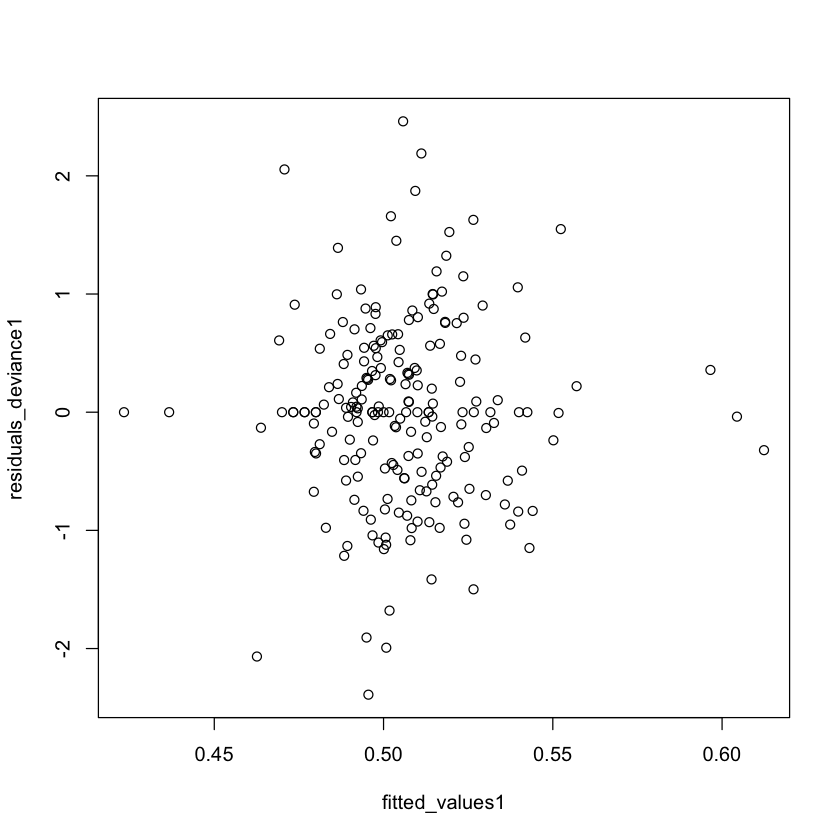

In [80]:
fitted_values1 <- predict(glm_model1, data= df, type = "response")

plot( fitted_values1, residuals_deviance1)

### Response distribution 

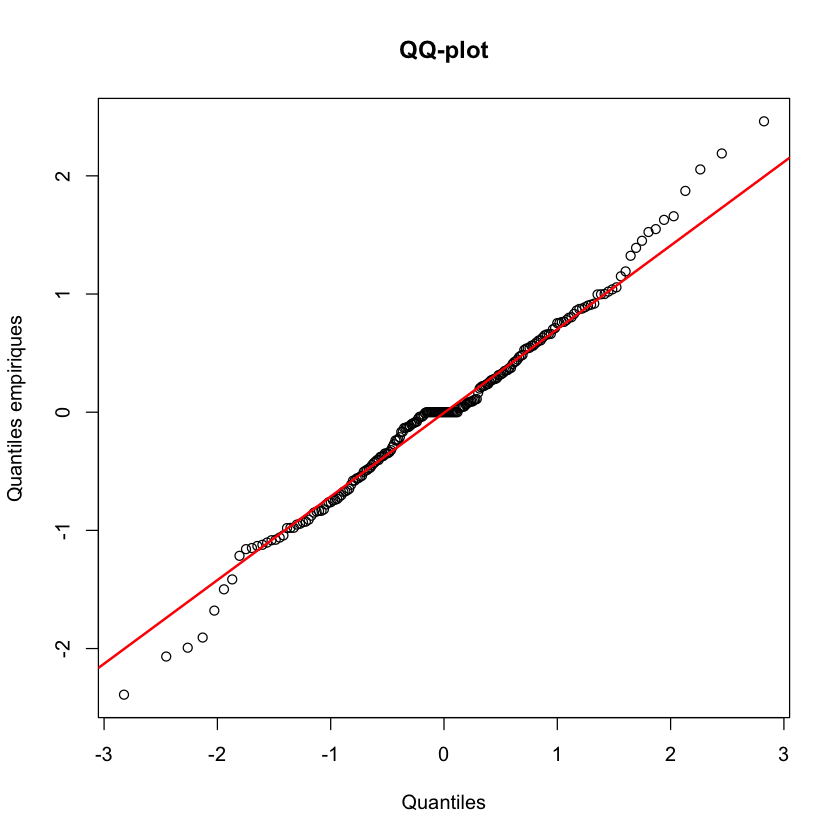

In [81]:
qqnorm(residuals_deviance1, main = "QQ-plot", xlab = "Quantiles", ylab = "Quantiles empiriques")

qqline(residuals_deviance1, col = "red", lwd = 2)

# Standardized deviance residuals 
residuals_d_std1 <- residuals_deviance1 / sqrt(1 - hatvalues(glm_model1))

#qqnorm(residuals_d_std1, main = "QQ-plot", xlab = "Quantiles", ylab = "Quantiles empiriques")

#qqline(residuals_d_std1, col = "red", lwd = 2)
# Not a big difference between them 


### Independence

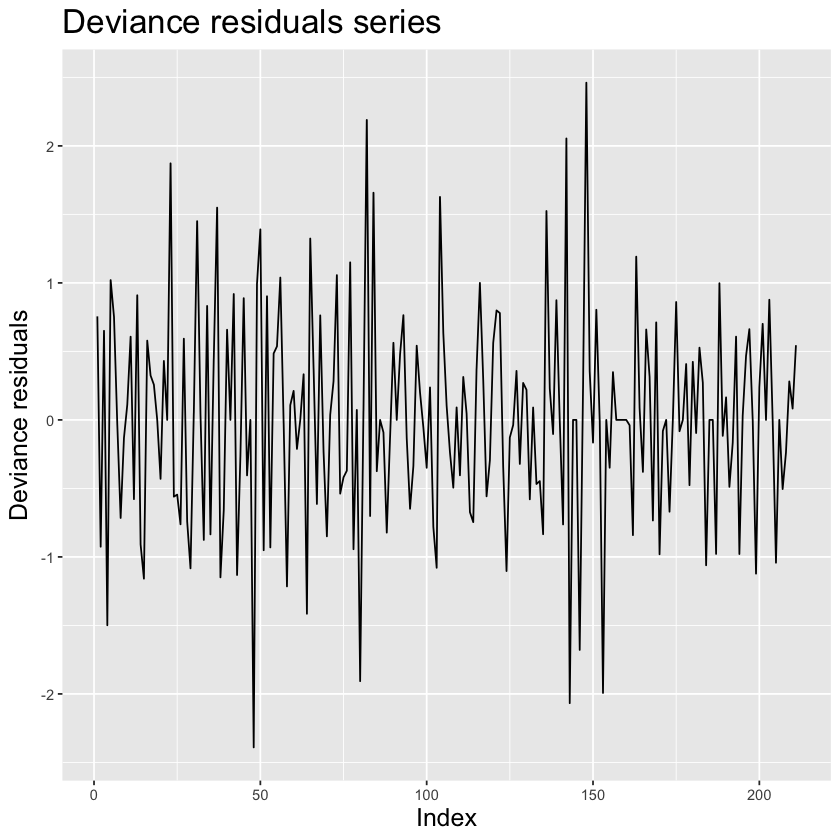

In [82]:
residuals_df1 <- data.frame(Residuals = residuals_deviance1, Index = seq_along(residuals_deviance1))
ggplot(residuals_df1, aes(x = Index, y = Residuals)) +
  geom_line() +
  labs(x = "Index", y = "Deviance residuals") +
  ggtitle("Deviance residuals series") +
  theme(axis.title = element_text(size = 15),  
        plot.title = element_text(size = 20))

### Cook's distance

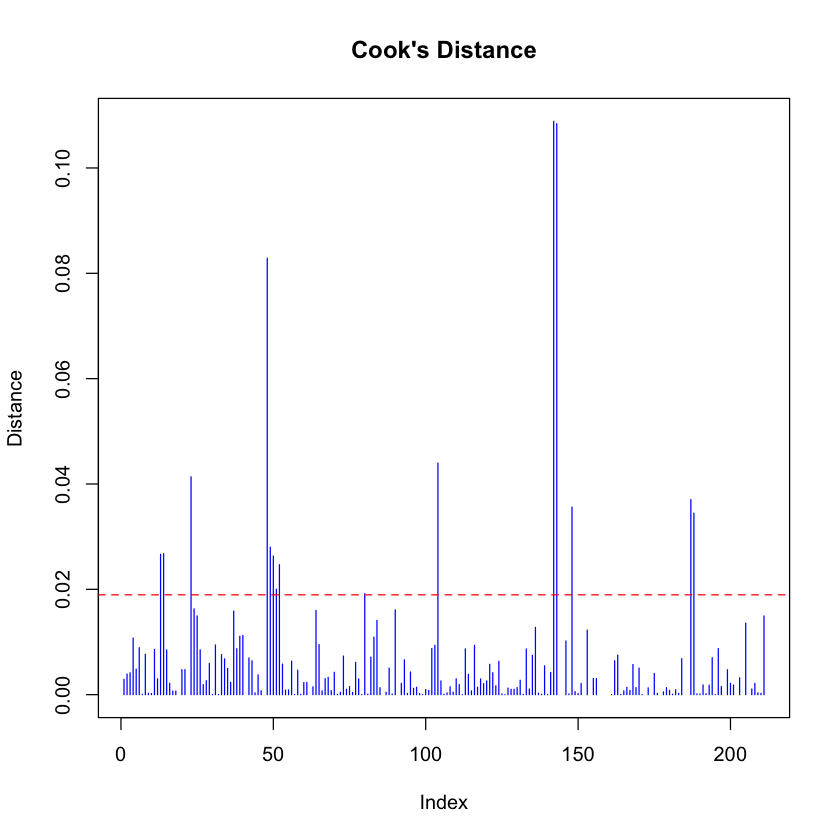

In [83]:
cooks_distance1 <- cooks.distance(glm_model1)

plot(cooks_distance1, main = "Cook's Distance", ylab = "Distance", type = "h", col = "blue")
abline(h = 4/(length(cooks_distance1)), col = "red", lty = 2) # rule of thumb 

In [84]:
threshold <- 4 / nrow(sampled_data_model)

influential_points <- which(cooks_distance1 > threshold)
influential_data <- sampled_data_model[influential_points, ]
print(influential_data)

# A tibble: 15 x 4
# Groups:   person [9]
   person            coin        m     y
   <chr>             <chr>   <int> <int>
 1 AntonZoubek       0.50EUR   300   150
 2 AntonZoubek       5SEK      300   141
 3 ChrisGabrielIslam 1EUR      300   169
 4 HannahArmstrong   1CAD      300   128
 5 HannahArmstrong   2CAD      300   163
 6 HannahArmstrong   2EUR      300   158
 7 JanYang           0.20EUR   300   153
 8 JanYang           0.50EUR   334   185
 9 MagdaMatetovici   0.50EUR   300   132
10 RietvanBork       1CHF      300   172
11 XiaoyiLin         0.20EUR   300   159
12 XiaoyiLin         0.50EUR   300   121
13 alexandraS        10CZK     300   173
14 jillR             0.20EUR   314   143
15 jillR             0.20GEL   301   155


## Performance

In [85]:
pred_probs1<- predict(glm_model1, type = "response")
print(mean(pred_probs1))

[1] 0.5063206


### ROC curve

Setting levels: control = 0, case = 1

Setting direction: controls < cases



Area under the curve: 0.8083

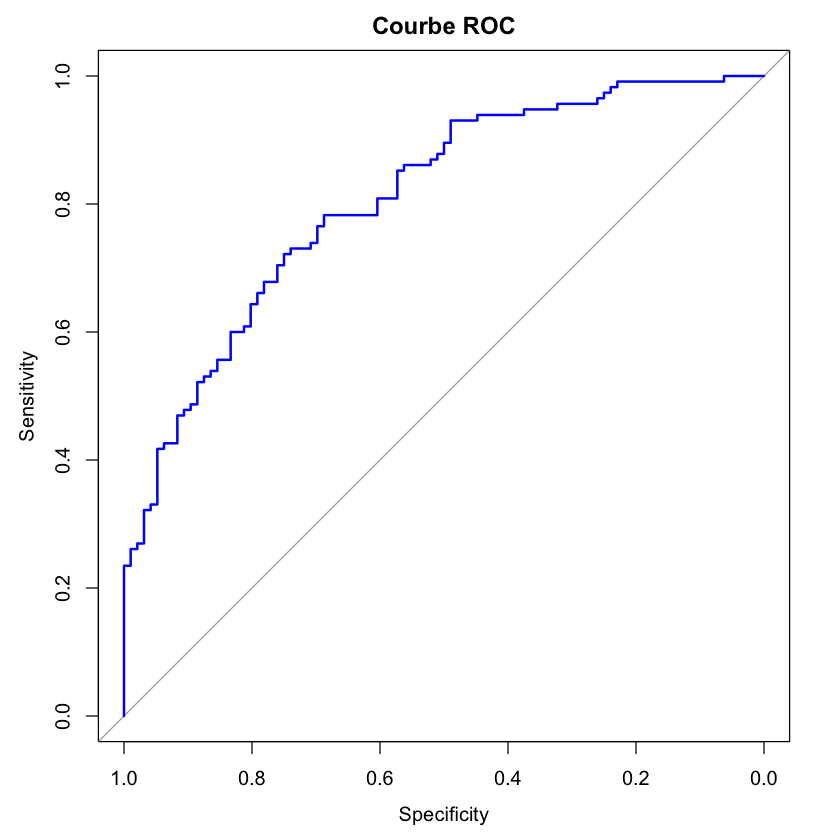

In [86]:
actual_classes1 <- ifelse(sampled_data_model$y > (sampled_data_model$m / 2), 1, 0)

roc_curve1 <- roc(actual_classes1, pred_probs1)

plot(roc_curve1, main = "Courbe ROC", col = "blue", lwd = 2)

auc(roc_curve1)

### Confusion matrix/ Accuracy

In [87]:

# Calculer les succès attendus (probabilité * nombre d'essais)
# Ici, m est le nombre total d'essais pour chaque observation
pred_successes1 <- pred_probs1 * sampled_data_model$m

# Convertir en classes binaires : succès ou échec
# Si le nombre de succès observé est supérieur à la moitié du nombre total d'essais, on peut dire que c'est un succès global
pred_classes1 <- ifelse(pred_successes1 > (sampled_data_model$m / 2), 1, 0)

# Convertir les valeurs réelles en classes binaires
# Si y (le nombre de succès observé) est supérieur à la moitié du nombre total d'essais, c'est un succès global
actual_classes1 <- ifelse(sampled_data_model$y > (sampled_data_model$m / 2), 1, 0)

# Créer la confusion matrix en comparant les classes binaires observées et prédites
confusion_matrix1 <- table(Predicted = pred_classes1, Actual = actual_classes1)

accuracy1 <- sum(diag(confusion_matrix1)) / sum(confusion_matrix1)
print(paste("Accuracy: ", accuracy1))

[1] "Accuracy:  0.706161137440758"


# Model with all data

## Model selection with all data

In [88]:
glmIntercept = glm(cbind(y,m-y)~1,family=binomial,data=df)
#summary(glmIntercept) 

glmTotal = glm(cbind(y,m-y)~1+person+coin,family=binomial,data=df)
#summary(glmTotal)

glmPerson = glm(cbind(y,m-y)~1+person,family=binomial,data=df)
summary(glmPerson)

glmCoin = glm(cbind(y,m-y)~1+coin,family=binomial,data=df)
#summary(glmCoin)


Call:
glm(formula = cbind(y, m - y) ~ 1 + person, family = binomial, 
    data = df)

Coefficients:
                           Estimate Std. Error z value Pr(>|z|)    
(Intercept)                0.062182   0.023261   2.673 0.007512 ** 
personAdrianKarami        -0.004519   0.041455  -0.109 0.913192    
personAndreeaZetea        -0.093009   0.037878  -2.455 0.014069 *  
personAntonZoubek         -0.035391   0.030675  -1.154 0.248607    
personArneJohn            -0.075516   0.039582  -1.908 0.056414 .  
personBohanFu             -0.029452   0.048577  -0.606 0.544319    
personChrisGabrielIslam   -0.074776   0.030674  -2.438 0.014778 *  
personEJ                  -0.041694   0.038946  -1.071 0.284369    
personFelipeFontanaVieira -0.082353   0.030668  -2.685 0.007246 ** 
personFranziskaAssion      0.101339   0.040009   2.533 0.011313 *  
personFranziskaNippold    -0.066087   0.030214  -2.187 0.028724 *  
personFrederikAust        -0.073992   0.030365  -2.437 0.014820 *  
personHannahArm

Some participants are statistically significant: the probability of landing on the same side of the coin as the initial side depends on the person flipping it, but only for certain individuals. Therefore, we can divide the participants into two groups: those who influence this probability, like JanYang, and those who do not, like Adrian Karami.

In [89]:
anova(glmIntercept, glmPerson, glmCoin, glmTotal, test = "LRT") # person + coin 

,Resid. Df,Resid. Dev,Df,Deviance,Pr(>Chi)
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,421,686.8612,NA,NA,NA
2,374,420.6084,47,266.2528,2.139090e-32
3,378,585.5556,-4,-164.9472,1.269778e-34
4,332,354.2164,46,231.3392,1.570205e-26


We can see on the previous table that adding both person and coin is statistically significant

In [90]:
step(glmTotal, direction = "backward", trace = 0) #person
step(glmTotal, direction = "both", trace = 0) #person
step(glmTotal, direction = "forward", trace = 0) # person + coin


Call:  glm(formula = cbind(y, m - y) ~ person, family = binomial, data = df)

Coefficients:
              (Intercept)         personAdrianKarami  
                 0.062182                  -0.004519  
       personAndreeaZetea          personAntonZoubek  
                -0.093009                  -0.035391  
           personArneJohn              personBohanFu  
                -0.075516                  -0.029452  
  personChrisGabrielIslam                   personEJ  
                -0.074776                  -0.041694  
personFelipeFontanaVieira      personFranziskaAssion  
                -0.082353                   0.101339  
   personFranziskaNippold         personFrederikAust  
                -0.066087                  -0.073992  
    personHannahArmstrong              personJanYang  
                -0.028846                   0.200705  
           personJasonNak            personJoycePang  
                -0.060988                  -0.103927  
          personKarolineH  


Call:  glm(formula = cbind(y, m - y) ~ person, family = binomial, data = df)

Coefficients:
              (Intercept)         personAdrianKarami  
                 0.062182                  -0.004519  
       personAndreeaZetea          personAntonZoubek  
                -0.093009                  -0.035391  
           personArneJohn              personBohanFu  
                -0.075516                  -0.029452  
  personChrisGabrielIslam                   personEJ  
                -0.074776                  -0.041694  
personFelipeFontanaVieira      personFranziskaAssion  
                -0.082353                   0.101339  
   personFranziskaNippold         personFrederikAust  
                -0.066087                  -0.073992  
    personHannahArmstrong              personJanYang  
                -0.028846                   0.200705  
           personJasonNak            personJoycePang  
                -0.060988                  -0.103927  
          personKarolineH  


Call:  glm(formula = cbind(y, m - y) ~ 1 + person + coin, family = binomial, 
    data = df)

Coefficients:
              (Intercept)         personAdrianKarami  
                -0.054801                  -0.007757  
       personAndreeaZetea          personAntonZoubek  
                -0.091120                  -0.037123  
           personArneJohn              personBohanFu  
                -0.078879                  -0.009212  
  personChrisGabrielIslam                   personEJ  
                -0.106006                  -0.047603  
personFelipeFontanaVieira      personFranziskaAssion  
                -0.081891                   0.103457  
   personFranziskaNippold         personFrederikAust  
                -0.055983                  -0.083067  
    personHannahArmstrong              personJanYang  
                -0.060384                   0.198208  
           personJasonNak            personJoycePang  
                -0.079157                  -0.159874  
          p

Variable selection: 
- forward selection: select only person
- both direction selection: select only person
- forward selection: select both person and coin

In [91]:
glm_model <- glm(cbind(y,m-y)~1+person,family=binomial,data=df)

In [92]:
alias(glm_model)

Model :
cbind(y, m - y) ~ 1 + person


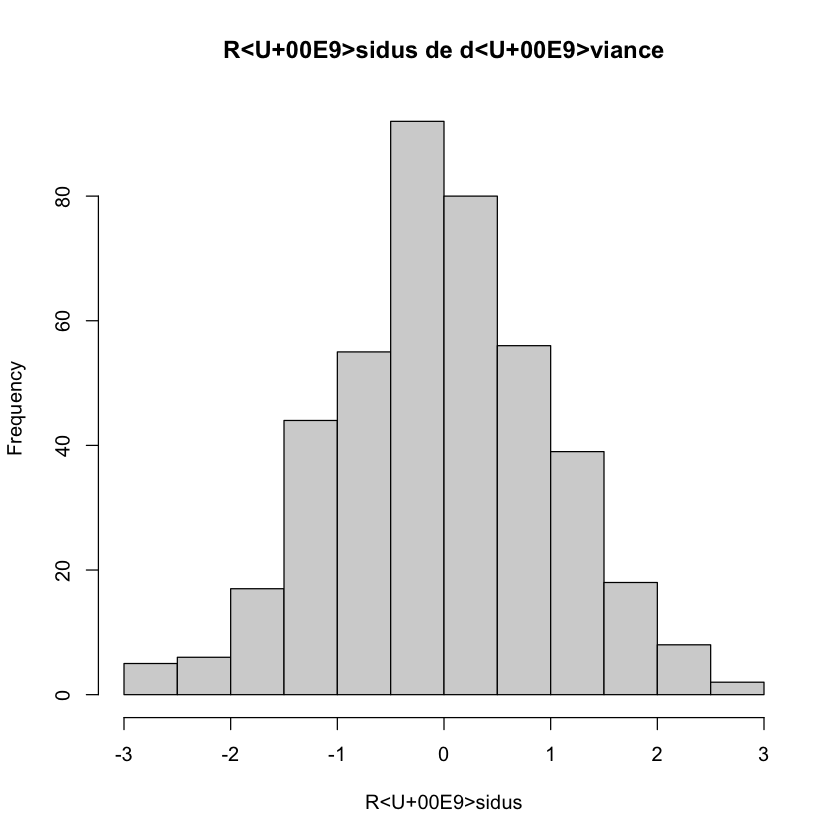

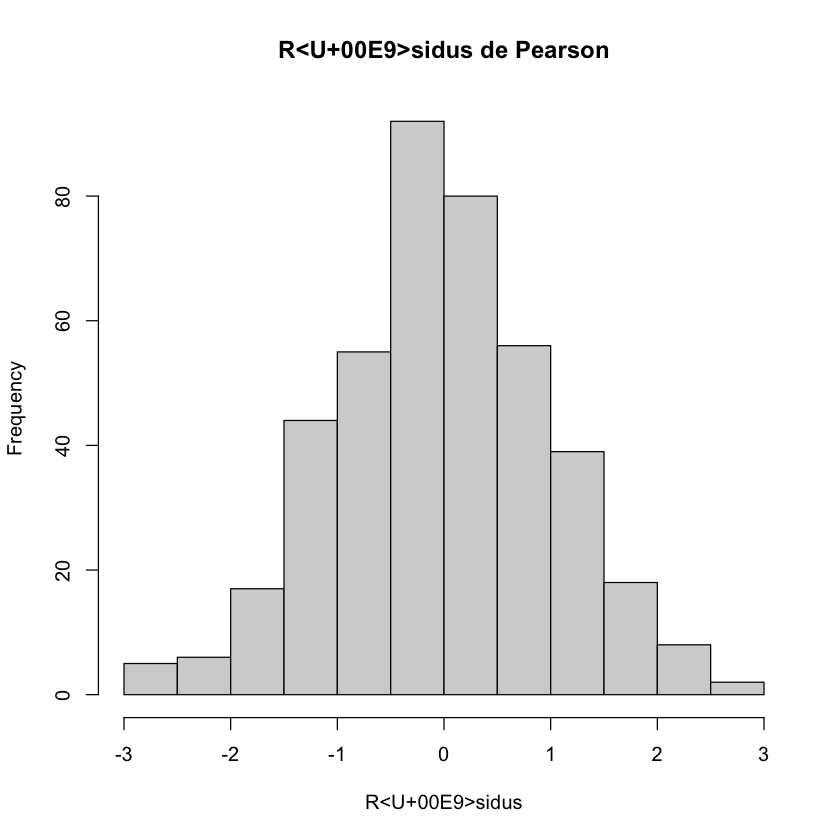

In [93]:
residuals_deviance <- residuals(glm_model, type = "deviance")
residuals_pearson <- residuals(glm_model, type = "pearson")

# Histogrammes des résidus
hist(residuals_deviance, breaks = 20, main = "Résidus de déviance", xlab = "Résidus")
hist(residuals_pearson, breaks = 20, main = "Résidus de Pearson", xlab = "Résidus")

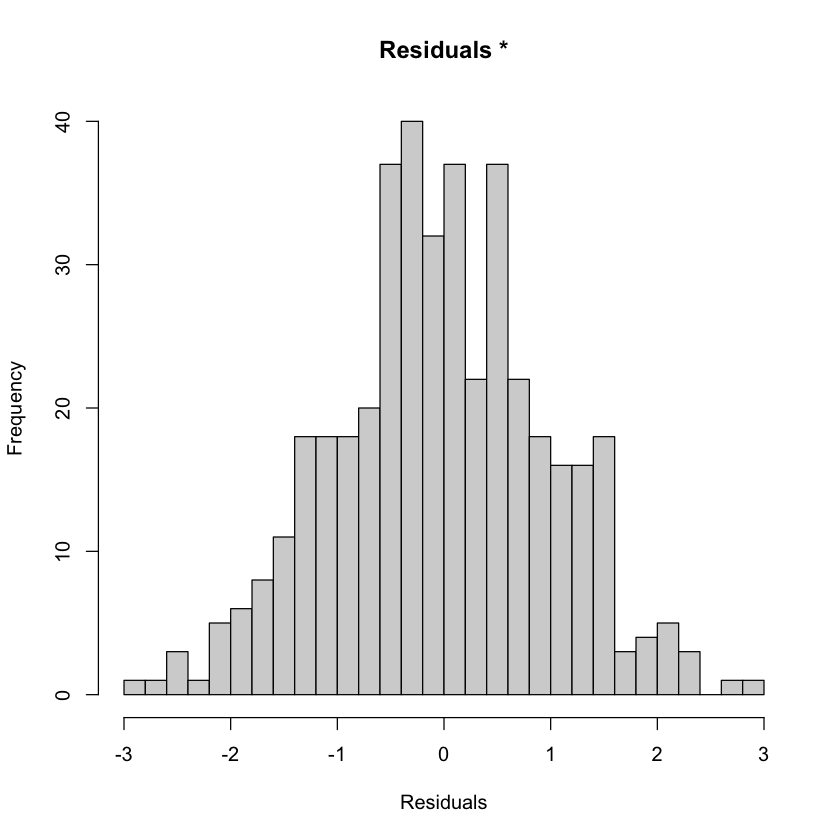

In [94]:
# Standardized deviance residual
std_deviance_residuals <- residuals_deviance / sqrt(1 - hatvalues(glm_model))

#Standardized pearson residual
std_pearson_residuals <- residuals_pearson / sqrt(1 - hatvalues(glm_model))

residuals <- residuals_deviance + log(residuals_pearson/residuals_deviance)/residuals_deviance # nolint

hist(residuals, breaks = 30, main = "Residuals *", xlab = "Residuals")


## Model checking

### 1. Linearity 

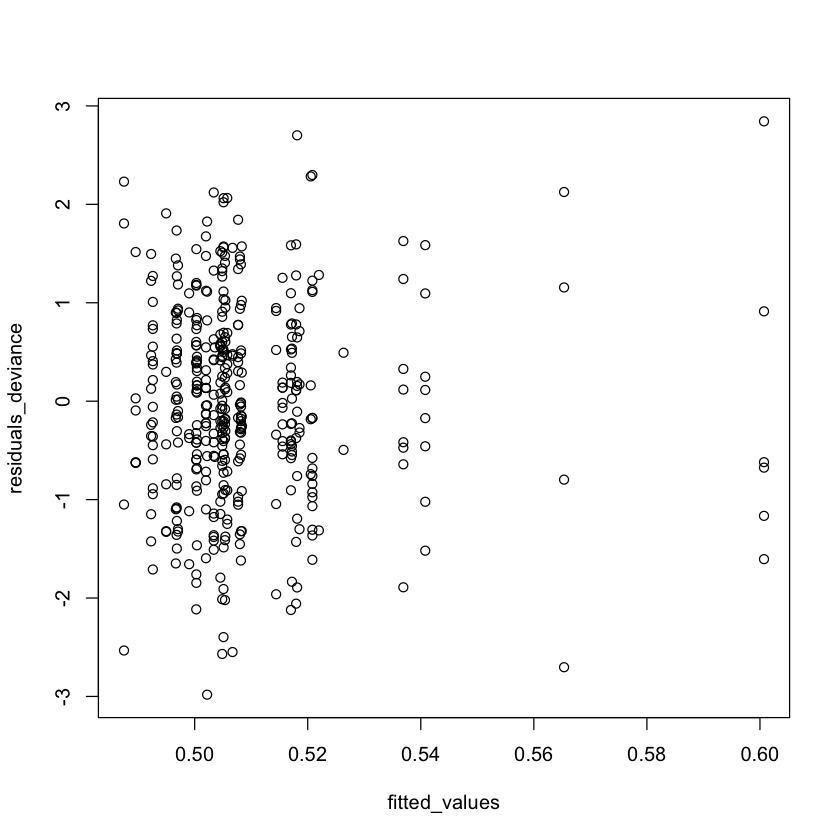

In [95]:
fitted_values <- predict(glm_model, data= df, type = "response")

plot( fitted_values, residuals_deviance)

• The deviance residuals versus fitted values plot indicates that the residuals are generally centered around zero, which is a positive sign for model fit.

•A high concentration of points is observed around fitted values between 0.50 and 0.52, suggesting the model struggles to differentiate observations in this range.

•Greater dispersion of residuals for fitted values above 0.54 may point to potential heteroscedasticity (non-constant variance).

•A few outliers or influential points are visible, particularly at the extremes of the residuals, warranting further investigation.

### 2. Response distribution

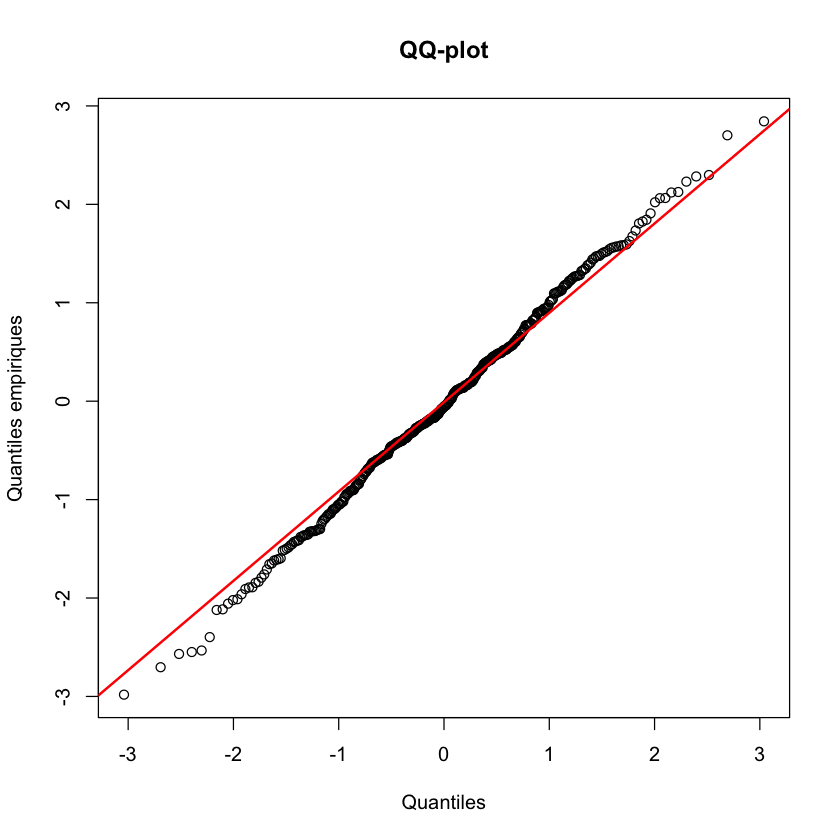

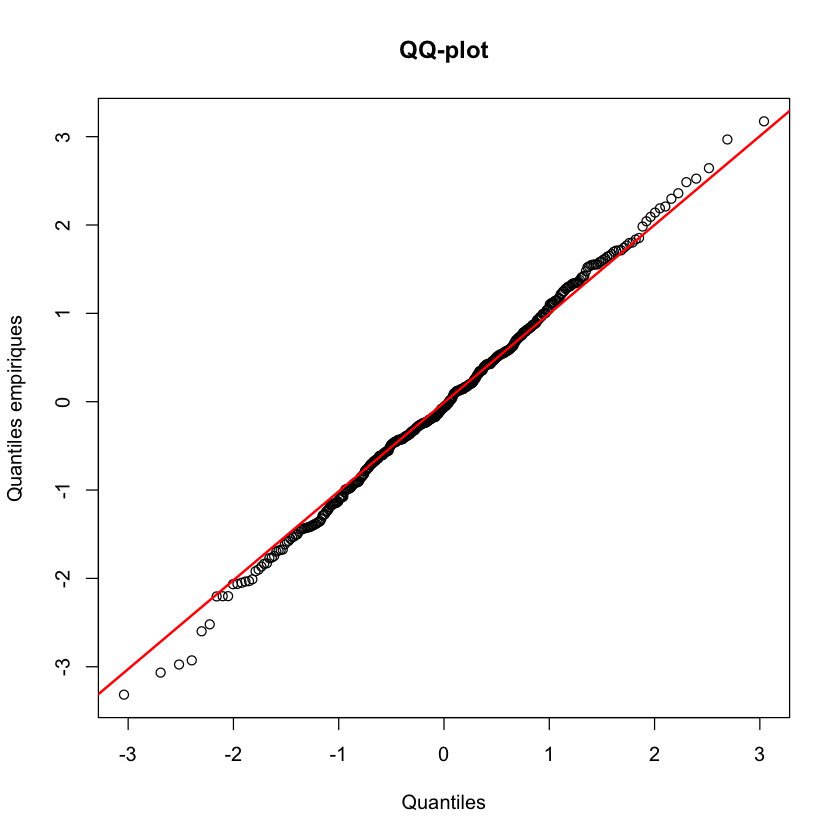

In [96]:
qqnorm(residuals_deviance, main = "QQ-plot", xlab = "Quantiles", ylab = "Quantiles empiriques")

qqline(residuals_deviance, col = "red", lwd = 2)

# Standardized deviance residuals 
residuals_d_std <- residuals_deviance / sqrt(1 - hatvalues(glm_model))

qqnorm(residuals_d_std, main = "QQ-plot", xlab = "Quantiles", ylab = "Quantiles empiriques")

qqline(residuals_d_std, col = "red", lwd = 2)
# Not a big difference between them 


• Good alignment: Most points follow the diagonal line, indicating the residuals generally follow a normal distribution.

• Tail deviations: Some deviations at the extremes suggest potential outliers or slight non-normality.

• Conclusion: The model fits well overall, with minor issues in the tails.

### 3. Independence (autocorrelation of the residuals)

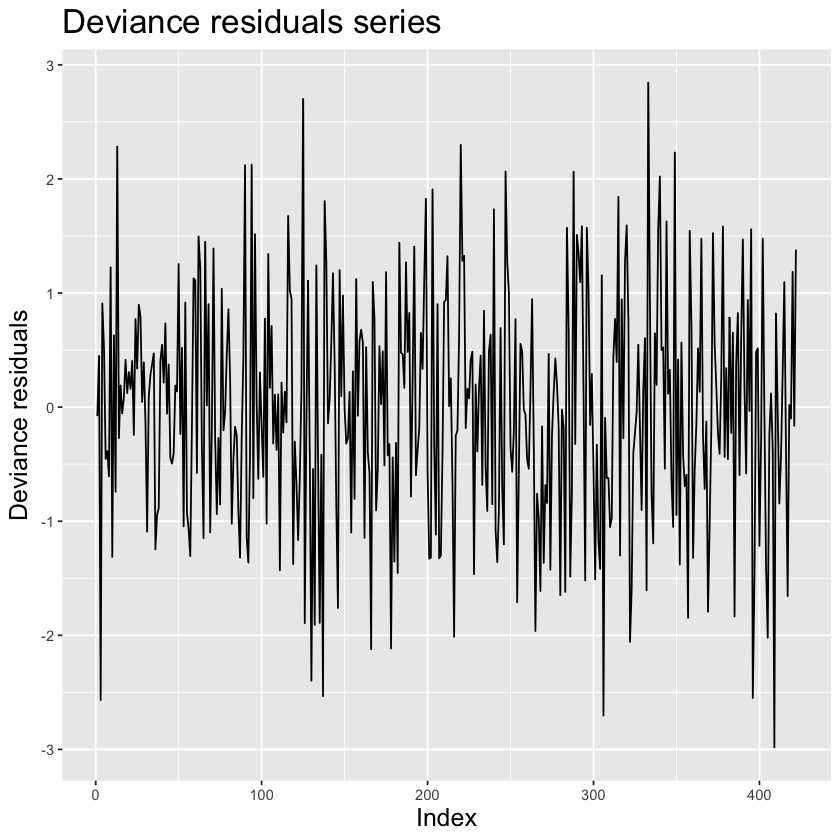

In [97]:
residuals_df <- data.frame(Residuals = residuals_deviance, Index = seq_along(residuals_deviance))
ggplot(residuals_df, aes(x = Index, y = Residuals)) +
  geom_line() +
  labs(x = "Index", y = "Deviance residuals") +
  ggtitle("Deviance residuals series") +
  theme(axis.title = element_text(size = 15),  
        plot.title = element_text(size = 20))

• Centered Around Zero: Residuals oscillate around zero, suggesting no major bias.

• Spread: Most values lie between -2 and 2, with a stable variance.

• Outliers: A few points near -3 or 3 may indicate potential outliers.

• Patterns: No clear trends or periodicity visible, suggesting independence.

### 4. Cook's distance

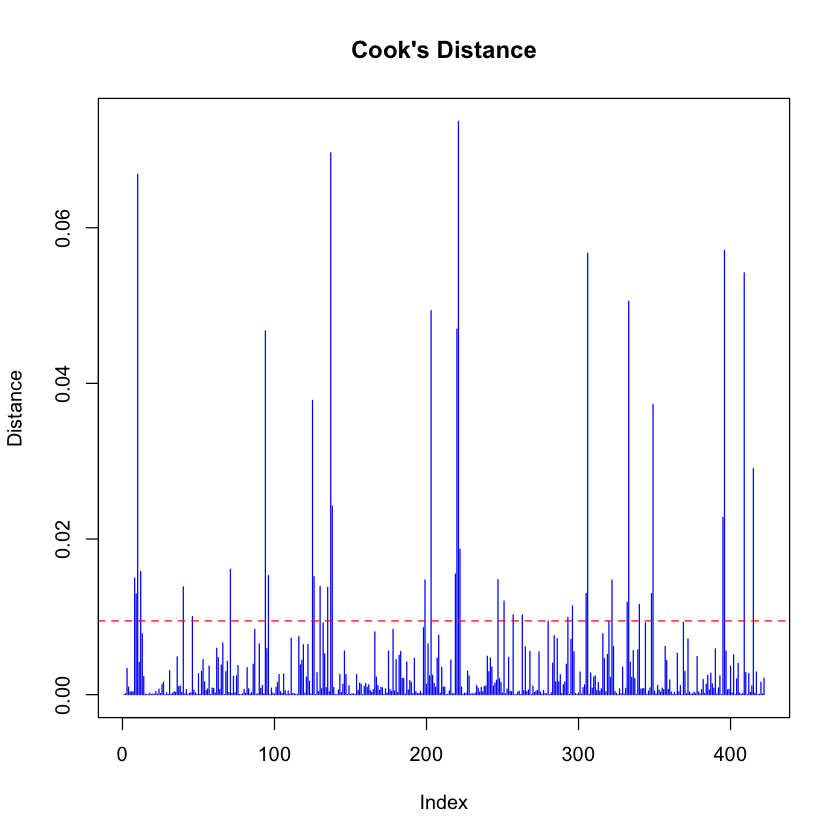

In [98]:
cooks_distance <- cooks.distance(glm_model)

plot(cooks_distance, main = "Cook's Distance", ylab = "Distance", type = "h", col = "blue")
abline(h = 4/(length(cooks_distance)), col = "red", lty = 2) # rule of thumb 

Since some people toss many more coins than others, some observations influence the model much more.

## Performance

### ROC curve and AUC 

In [99]:
pred_probs<- predict(glm_model, type = "response")
print(mean(pred_probs))

[1] 0.5084848


Setting levels: control = 0, case = 1

Setting direction: controls < cases



Area under the curve: 0.687

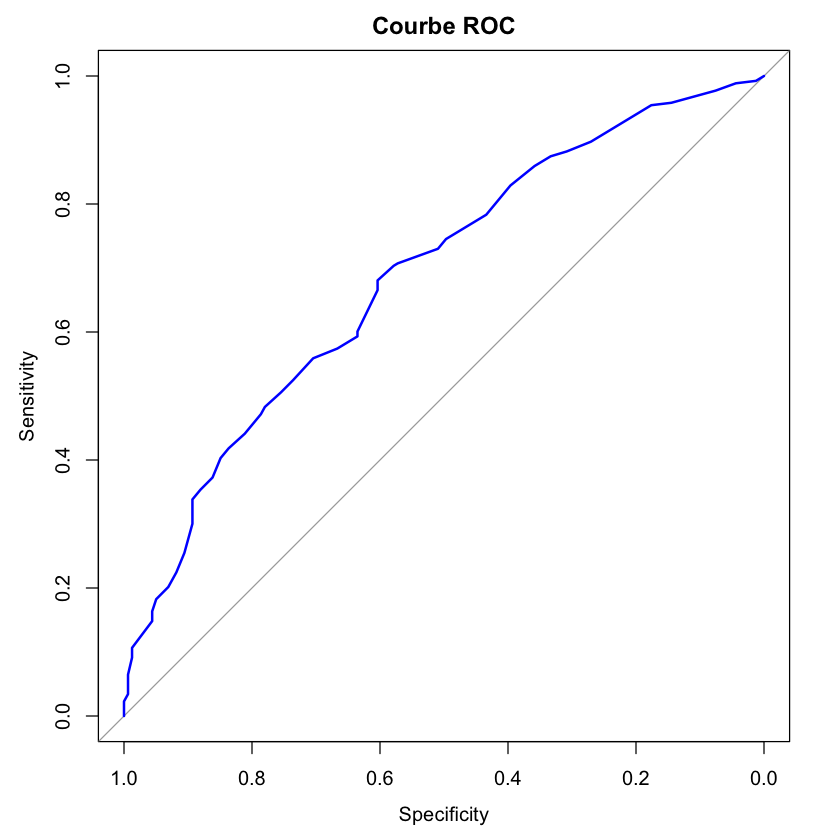

In [100]:
actual_classes <- ifelse(df$y > (df$m / 2), 1, 0)

roc_curve <- roc(actual_classes, pred_probs)

plot(roc_curve, main = "Courbe ROC", col = "blue", lwd = 2)

auc(roc_curve)

### Confusion matrix and accuracy

In [101]:

# Prédire les probabilités de succès avec le modèle (pour chaque observation)
pred_probs <- predict(glm_model, type = "response")

# Calculer les succès attendus (probabilité * nombre d'essais)
# Ici, m est le nombre total d'essais pour chaque observation
pred_successes <- pred_probs * df$m

# Convertir en classes binaires : succès ou échec
# Si le nombre de succès observé est supérieur à la moitié du nombre total d'essais, on peut dire que c'est un succès global
pred_classes <- ifelse(pred_successes > (df$m / 2), 1, 0)

# Convertir les valeurs réelles en classes binaires
# Si y (le nombre de succès observé) est supérieur à la moitié du nombre total d'essais, c'est un succès global
actual_classes <- ifelse(df$y > (df$m / 2), 1, 0)

# Créer la confusion matrix en comparant les classes binaires observées et prédites
confusion_matrix <- table(Predicted = pred_classes, Actual = actual_classes)

accuracy <- sum(diag(confusion_matrix)) / sum(confusion_matrix)
print(paste("Accuracy: ", accuracy))

[1] "Accuracy:  0.670616113744076"


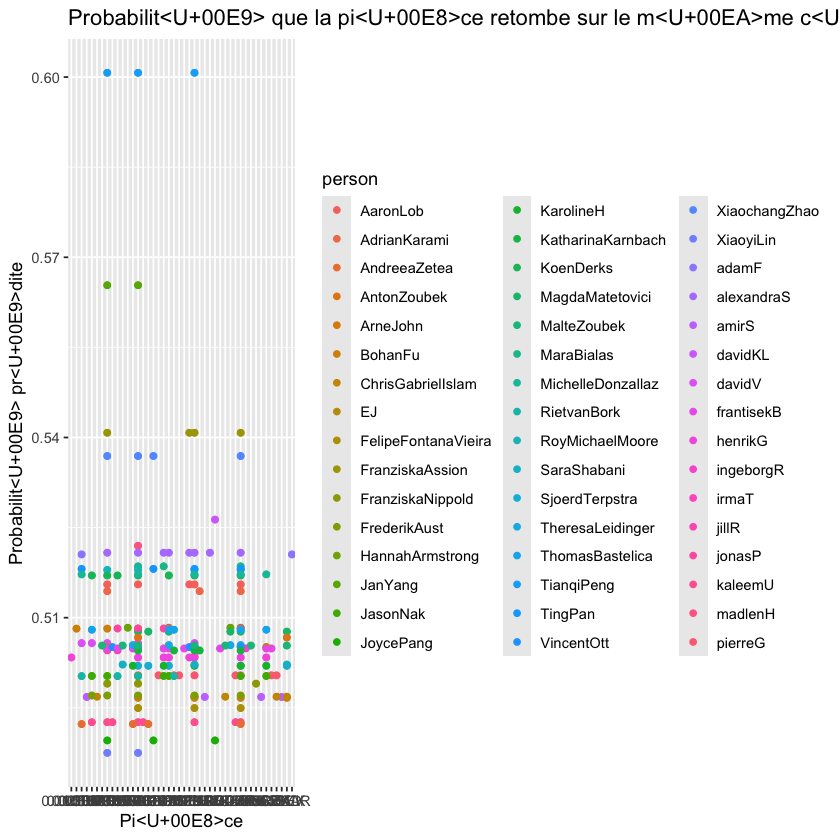

In [102]:
df$predicted_probs <- pred_probs

ggplot(df, aes(x = coin, y = predicted_probs, color = person)) +
  geom_point() +
  labs(title = "Probabilité que la pièce retombe sur le même côté",
       y = "Probabilité prédite", x = "Pièce")